In [11]:
import pandas as pd
import numpy as np
from IPython.display import display
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
import seaborn as sns

# DataFrame laden
df = pd.read_csv('konvertierte_berichte_ML_long.csv')


In [12]:
# === 1. FEATURE AUSWAHL: Nur Variablen mit echter Streuung (A, DA, SA, Scan) ===

def parse_percent(val):
    try:
        return float(val.replace('%', '').replace(',', '.'))
    except:
        return np.nan

def parse_mm(val):
    try:
        if val == '--- mm':
            return np.nan
        return float(val.replace('mm', '').replace(',', '.'))
    except:
        return np.nan

def parse_deg(val):
    try:
        if val == '--- º' or val == '---º':
            return np.nan
        return float(val.replace('º', '').replace(',', '.'))
    except:
        return np.nan

# Parse nur die relevanten Spalten
df['A_parsed'] = df['A'].astype(str).apply(parse_percent)
df['DA_parsed'] = df['DA'].astype(str).apply(parse_mm)
df['SA_parsed'] = df['SA'].astype(str).apply(parse_mm)  # SA ist in dB, aber als mm formatiert
df['Scan_parsed'] = df['Scan'].astype(str).apply(parse_mm)

# Feature-Matrix mit nur den 4 relevanten Variablen erstellen
feature_columns = ['A_parsed', 'DA_parsed', 'SA_parsed', 'Scan_parsed']
X_features = df[feature_columns].copy()

print("=== FEATURE AUSWAHL ===")
print(f"Ausgewählte Features: {feature_columns}")
print(f"Shape der Feature-Matrix: {X_features.shape}")
print("\nStatistiken der ausgewählten Features:")
display(X_features.describe())

# Fehlende Werte behandeln
print(f"\nFehlende Werte pro Feature:")
print(X_features.isnull().sum())

# Imputation der fehlenden Werte
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X_features)
X_features_clean = pd.DataFrame(X_imputed, columns=feature_columns)

print(f"\nNach Imputation - Fehlende Werte: {X_features_clean.isnull().sum().sum()}")


=== FEATURE AUSWAHL ===
Ausgewählte Features: ['A_parsed', 'DA_parsed', 'SA_parsed', 'Scan_parsed']
Shape der Feature-Matrix: (704, 4)

Statistiken der ausgewählten Features:


,A_parsed,DA_parsed,SA_parsed,Scan_parsed
count,704.000000,474.000000,474.000000,704.000000
mean,88.925710,39.213945,48.342743,129.038352
std,87.878788,18.901299,23.671785,168.223222
min,2.900000,25.000000,30.520000,0.000000
25%,31.050000,25.240000,30.810000,0.000000
50%,53.800000,25.320000,30.910000,0.000000
75%,77.300000,59.407500,76.135000,350.000000
max,250.000000,80.780000,99.780000,350.000000



Fehlende Werte pro Feature:
A_parsed         0
DA_parsed      230
SA_parsed      230
Scan_parsed      0
dtype: int64

Nach Imputation - Fehlende Werte: 0


=== SKALIERUNG ===
Vor Skalierung - Statistiken:


,A_parsed,DA_parsed,SA_parsed,Scan_parsed
count,704.000000,704.000000,704.000000,704.000000
mean,88.925710,39.213945,48.342743,129.038352
std,87.878788,15.504029,19.417080,168.223222
min,2.900000,25.000000,30.520000,0.000000
25%,31.050000,25.270000,30.840000,0.000000
50%,53.800000,39.213945,48.342743,0.000000
75%,77.300000,46.217500,56.505000,350.000000
max,250.000000,80.780000,99.780000,350.000000



Nach Z-Score Skalierung - Statistiken:


,A_parsed,DA_parsed,SA_parsed,Scan_parsed
count,7.040000e+02,7.040000e+02,7.040000e+02,7.040000e+02
mean,2.270911e-16,-4.743680e-16,-7.165985e-16,-8.957481e-17
std,1.000711e+00,1.000711e+00,1.000711e+00,1.000711e+00
min,-9.796092e-01,-9.174423e-01,-9.185426e-01,-7.676116e-01
25%,-6.590539e-01,-9.000151e-01,-9.020505e-01,-7.676116e-01
50%,-3.999905e-01,-4.586214e-16,-7.323943e-16,-7.676116e-01
75%,-1.323866e-01,4.520460e-01,4.206637e-01,1.314437e+00
max,1.834218e+00,2.682890e+00,2.650956e+00,1.314437e+00


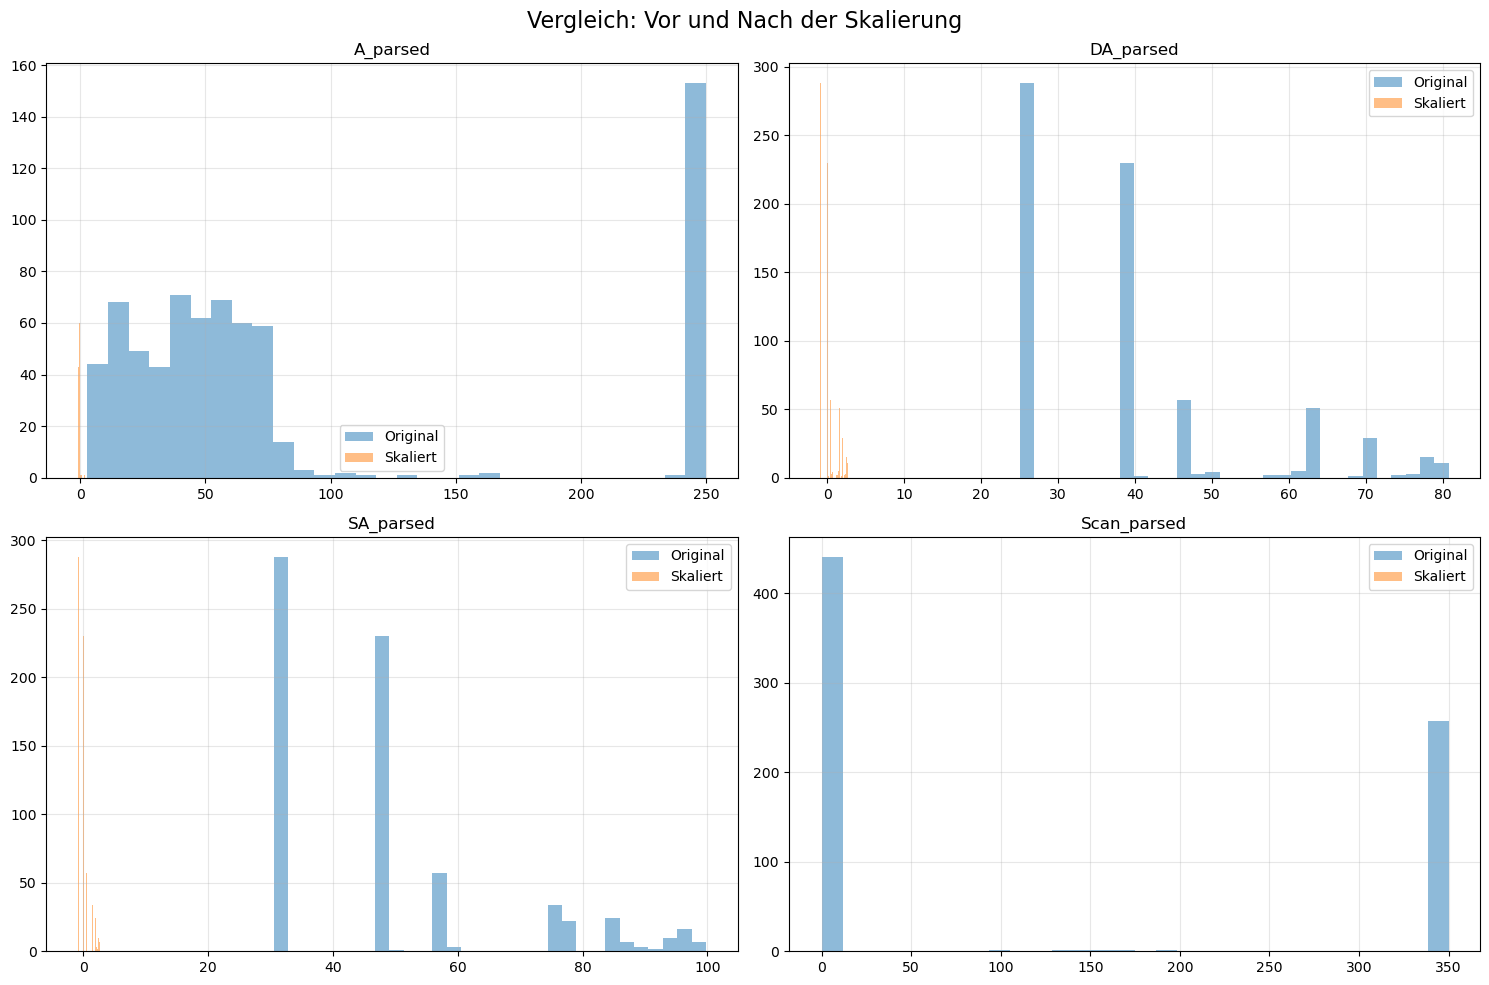

In [13]:
# === 2. SKALIERUNG: StandardScaler für einheitlichen Wertebereich ===

print("=== SKALIERUNG ===")
print("Vor Skalierung - Statistiken:")
display(X_features_clean.describe())

# Z-Score Standardisierung
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_features_clean)
X_scaled_df = pd.DataFrame(X_scaled, columns=feature_columns)

print("\nNach Z-Score Skalierung - Statistiken:")
display(X_scaled_df.describe())

# Visualisierung der Skalierung
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Vergleich: Vor und Nach der Skalierung', fontsize=16)

for i, col in enumerate(feature_columns):
    row = i // 2
    col_idx = i % 2

    axes[row, col_idx].hist(X_features_clean[col], alpha=0.5, label='Original', bins=30)
    axes[row, col_idx].hist(X_scaled_df[col], alpha=0.5, label='Skaliert', bins=30)
    axes[row, col_idx].set_title(f'{col}')
    axes[row, col_idx].legend()
    axes[row, col_idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


=== PCA DIMENSIONALITÄTSREDUKTION ===
Erklärte Varianz pro Komponente:
PC1: 0.621 (62.1%)
PC2: 0.256 (25.6%)
PC3: 0.121 (12.1%)
PC4: 0.002 (0.2%)

Kumulative erklärte Varianz:
PC1-PC1: 0.621 (62.1%)
PC1-PC2: 0.877 (87.7%)
PC1-PC3: 0.998 (99.8%)
PC1-PC4: 1.000 (100.0%)


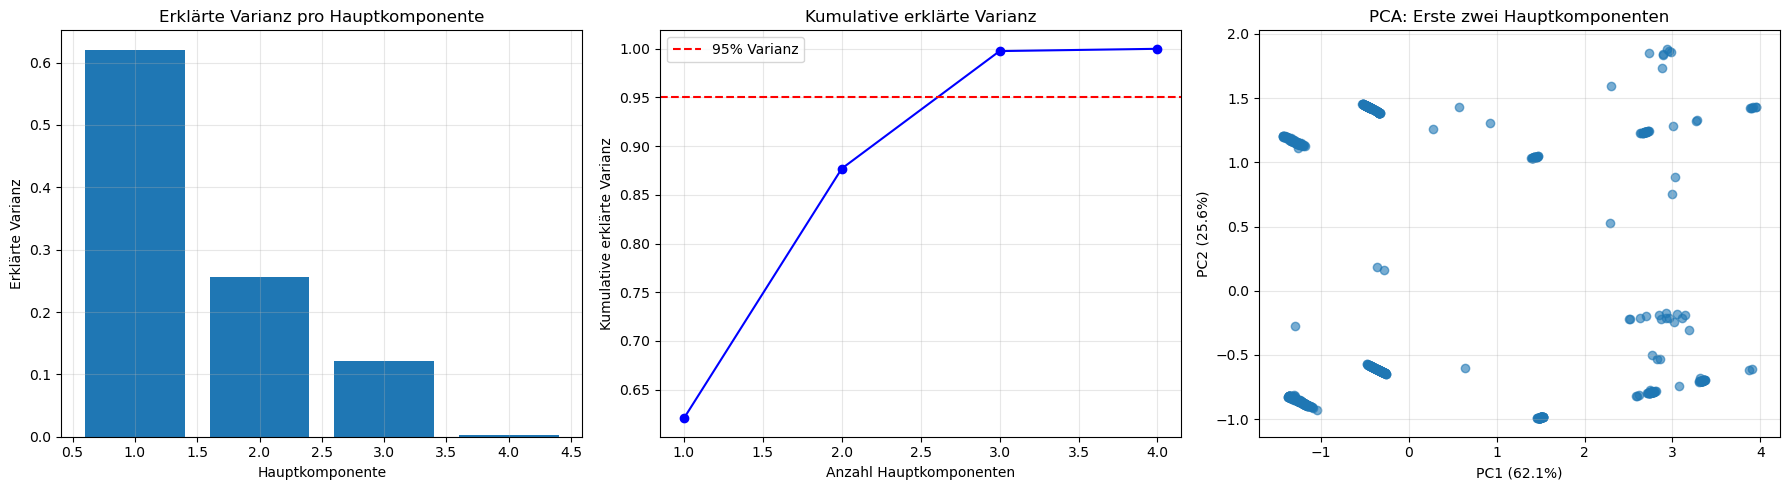


Feature-Ladungen (Contribution zu den Hauptkomponenten):


,PC1,PC2
A_parsed,0.500090,-0.178310
DA_parsed,0.611806,0.095842
SA_parsed,0.612213,0.094860
Scan_parsed,-0.028255,0.974690


In [14]:
# === 3. DIMENSIONALITÄTSREDUKTION: PCA ===

print("=== PCA DIMENSIONALITÄTSREDUKTION ===")

# PCA mit allen 4 Komponenten für Analyse
pca_full = PCA()
X_pca_full = pca_full.fit_transform(X_scaled)

# Erklärte Varianz anzeigen
explained_variance = pca_full.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

print("Erklärte Varianz pro Komponente:")
for i, var in enumerate(explained_variance):
    print(f"PC{i+1}: {var:.3f} ({var*100:.1f}%)")

print(f"\nKumulative erklärte Varianz:")
for i, cum_var in enumerate(cumulative_variance):
    print(f"PC1-PC{i+1}: {cum_var:.3f} ({cum_var*100:.1f}%)")

# PCA für 2D-Visualisierung
pca_2d = PCA(n_components=2)
X_pca_2d = pca_2d.fit_transform(X_scaled)

# Visualisierung der PCA-Ergebnisse
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Erklärte Varianz
axes[0].bar(range(1, len(explained_variance)+1), explained_variance)
axes[0].set_xlabel('Hauptkomponente')
axes[0].set_ylabel('Erklärte Varianz')
axes[0].set_title('Erklärte Varianz pro Hauptkomponente')
axes[0].grid(True, alpha=0.3)

# Kumulative erklärte Varianz
axes[1].plot(range(1, len(cumulative_variance)+1), cumulative_variance, 'bo-')
axes[1].axhline(y=0.95, color='r', linestyle='--', label='95% Varianz')
axes[1].set_xlabel('Anzahl Hauptkomponenten')
axes[1].set_ylabel('Kumulative erklärte Varianz')
axes[1].set_title('Kumulative erklärte Varianz')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# 2D PCA Scatterplot
axes[2].scatter(X_pca_2d[:, 0], X_pca_2d[:, 1], alpha=0.6)
axes[2].set_xlabel(f'PC1 ({explained_variance[0]*100:.1f}%)')
axes[2].set_ylabel(f'PC2 ({explained_variance[1]*100:.1f}%)')
axes[2].set_title('PCA: Erste zwei Hauptkomponenten')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Feature-Ladungen anzeigen
print("\nFeature-Ladungen (Contribution zu den Hauptkomponenten):")
loadings = pd.DataFrame(
    pca_2d.components_.T,
    columns=['PC1', 'PC2'],
    index=feature_columns
)
display(loadings)


=== CLUSTERING ANALYSE ===


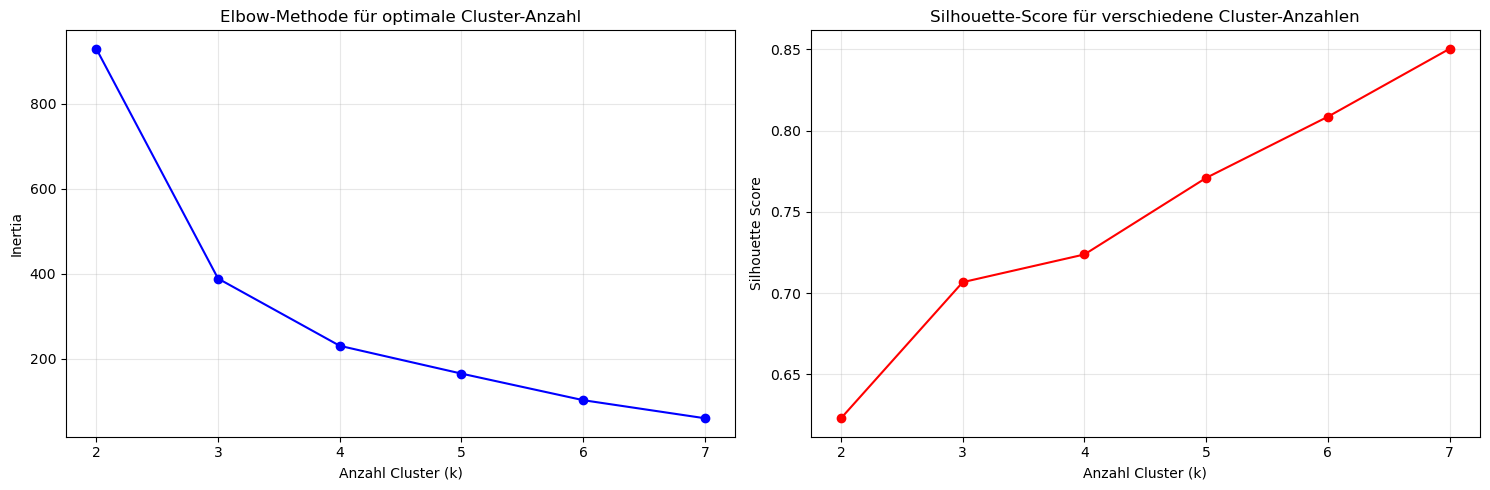

Optimale Cluster-Anzahl (Silhouette): 7


In [15]:
# === 4. CLUSTERING ===

print("=== CLUSTERING ANALYSE ===")

# K-Means mit verschiedenen Cluster-Anzahlen testen
inertias = []
silhouette_scores = []
k_range = range(2, 8)

from sklearn.metrics import silhouette_score

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_pca_2d)
    inertias.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_pca_2d, kmeans.labels_))

# Optimale Cluster-Anzahl finden
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Elbow-Methode
axes[0].plot(k_range, inertias, 'bo-')
axes[0].set_xlabel('Anzahl Cluster (k)')
axes[0].set_ylabel('Inertia')
axes[0].set_title('Elbow-Methode für optimale Cluster-Anzahl')
axes[0].grid(True, alpha=0.3)

# Silhouette-Score
axes[1].plot(k_range, silhouette_scores, 'ro-')
axes[1].set_xlabel('Anzahl Cluster (k)')
axes[1].set_ylabel('Silhouette Score')
axes[1].set_title('Silhouette-Score für verschiedene Cluster-Anzahlen')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Beste Cluster-Anzahl basierend auf Silhouette-Score
optimal_k = k_range[np.argmax(silhouette_scores)]
print(f"Optimale Cluster-Anzahl (Silhouette): {optimal_k}")


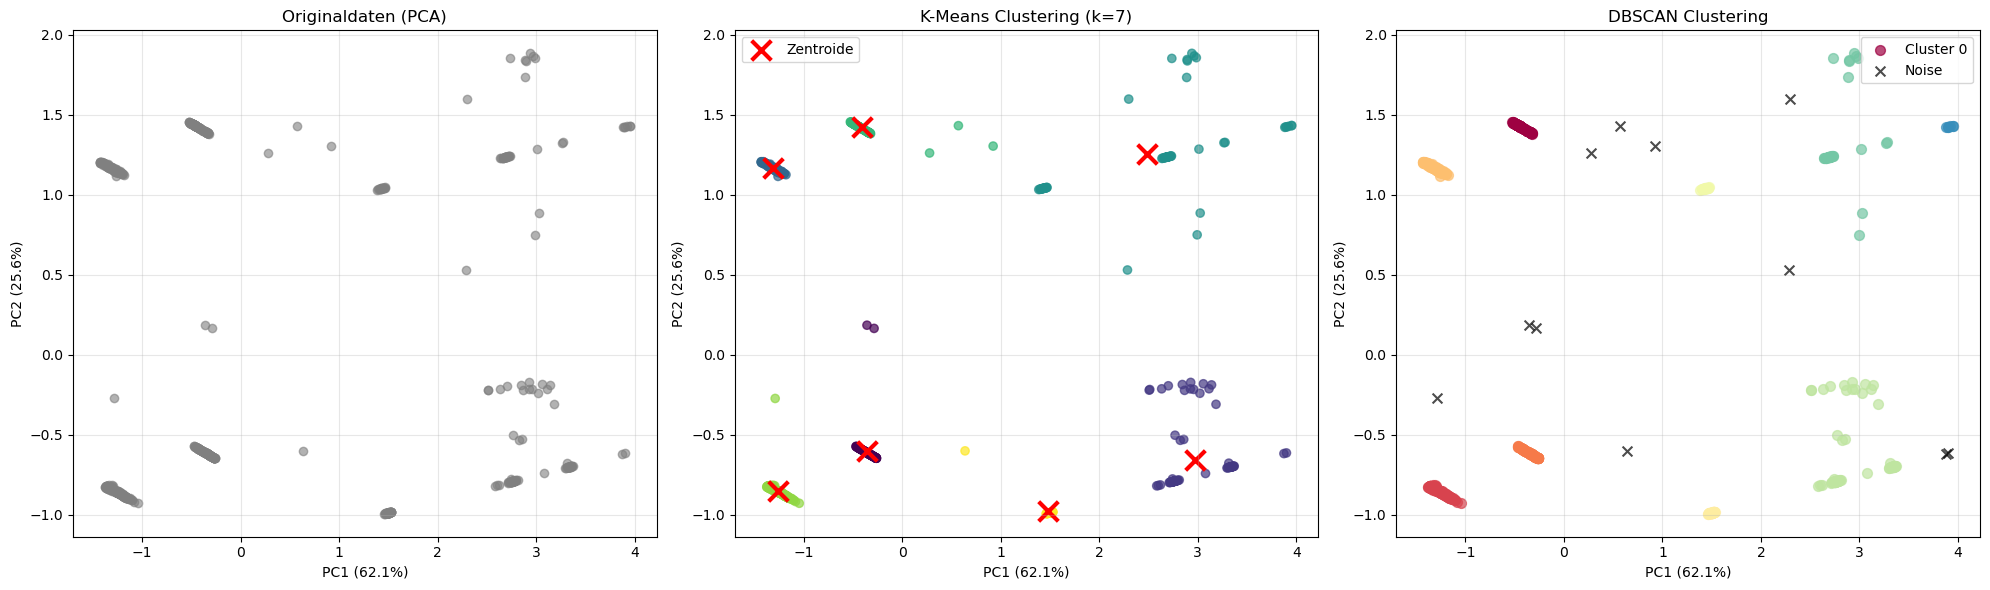

=== CLUSTERING STATISTIKEN ===
K-Means (k=7):
  Silhouette Score: 0.850
  Cluster 0: 112 Punkte
  Cluster 1: 86 Punkte
  Cluster 2: 83 Punkte
  Cluster 3: 56 Punkte
  Cluster 4: 121 Punkte
  Cluster 5: 205 Punkte
  Cluster 6: 41 Punkte

DBSCAN:
  Silhouette Score: 0.863
  Noise: 11 Punkte
  Cluster 0: 118 Punkte
  Cluster 1: 204 Punkte
  Cluster 2: 110 Punkte
  Cluster 3: 83 Punkte
  Cluster 4: 40 Punkte
  Cluster 5: 17 Punkte
  Cluster 6: 84 Punkte
  Cluster 7: 31 Punkte
  Cluster 8: 6 Punkte

Cluster-Labels wurden dem DataFrame hinzugefügt.
Verfügbare neue Spalten: ['cluster_kmeans', 'cluster_dbscan', 'pca_1', 'pca_2']


In [16]:
# === FINALE CLUSTERING-ERGEBNISSE ===

# K-Means mit optimaler Cluster-Anzahl
kmeans_optimal = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
kmeans_labels = kmeans_optimal.fit_predict(X_pca_2d)

# DBSCAN als Alternative
dbscan = DBSCAN(eps=0.5, min_samples=5)
dbscan_labels = dbscan.fit_predict(X_pca_2d)

# Visualisierung der Clustering-Ergebnisse
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# Originaldaten ohne Clustering
axes[0].scatter(X_pca_2d[:, 0], X_pca_2d[:, 1], alpha=0.6, c='gray')
axes[0].set_xlabel(f'PC1 ({explained_variance[0]*100:.1f}%)')
axes[0].set_ylabel(f'PC2 ({explained_variance[1]*100:.1f}%)')
axes[0].set_title('Originaldaten (PCA)')
axes[0].grid(True, alpha=0.3)

# K-Means Clustering
scatter1 = axes[1].scatter(X_pca_2d[:, 0], X_pca_2d[:, 1],
                          c=kmeans_labels, cmap='viridis', alpha=0.7)
axes[1].scatter(kmeans_optimal.cluster_centers_[:, 0],
                kmeans_optimal.cluster_centers_[:, 1],
                c='red', marker='x', s=200, linewidths=3, label='Zentroide')
axes[1].set_xlabel(f'PC1 ({explained_variance[0]*100:.1f}%)')
axes[1].set_ylabel(f'PC2 ({explained_variance[1]*100:.1f}%)')
axes[1].set_title(f'K-Means Clustering (k={optimal_k})')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# DBSCAN Clustering
unique_labels = set(dbscan_labels)
colors = plt.cm.Spectral(np.linspace(0, 1, len(unique_labels)))

for k, col in zip(unique_labels, colors):
    if k == -1:
        # Noise points
        col = 'black'
        marker = 'x'
        label = 'Noise'
    else:
        marker = 'o'
        label = f'Cluster {k}'

    class_member_mask = (dbscan_labels == k)
    xy = X_pca_2d[class_member_mask]
    axes[2].scatter(xy[:, 0], xy[:, 1], c=[col], marker=marker,
                   alpha=0.7, s=50, label=label if k in [-1, 0] else "")

axes[2].set_xlabel(f'PC1 ({explained_variance[0]*100:.1f}%)')
axes[2].set_ylabel(f'PC2 ({explained_variance[1]*100:.1f}%)')
axes[2].set_title('DBSCAN Clustering')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Clustering-Statistiken
print("=== CLUSTERING STATISTIKEN ===")
print(f"K-Means (k={optimal_k}):")
print(f"  Silhouette Score: {silhouette_score(X_pca_2d, kmeans_labels):.3f}")
unique_kmeans, counts_kmeans = np.unique(kmeans_labels, return_counts=True)
for label, count in zip(unique_kmeans, counts_kmeans):
    print(f"  Cluster {label}: {count} Punkte")

print(f"\nDBSCAN:")
if len(set(dbscan_labels)) > 1:
    print(f"  Silhouette Score: {silhouette_score(X_pca_2d, dbscan_labels):.3f}")
unique_dbscan, counts_dbscan = np.unique(dbscan_labels, return_counts=True)
for label, count in zip(unique_dbscan, counts_dbscan):
    if label == -1:
        print(f"  Noise: {count} Punkte")
    else:
        print(f"  Cluster {label}: {count} Punkte")

# Ergebnisse zum ursprünglichen DataFrame hinzufügen
df['cluster_kmeans'] = kmeans_labels
df['cluster_dbscan'] = dbscan_labels
df['pca_1'] = X_pca_2d[:, 0]
df['pca_2'] = X_pca_2d[:, 1]

print(f"\nCluster-Labels wurden dem DataFrame hinzugefügt.")
print(f"Verfügbare neue Spalten: ['cluster_kmeans', 'cluster_dbscan', 'pca_1', 'pca_2']")


In [27]:
import numpy as np
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
from sklearn.metrics import pairwise_distances_argmin_min

# ——— Annahme: du hast deine Daten in X_scaled (standardisiert) ———
# 1) PCA trainieren
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)
df['pca_1'], df['pca_2'] = X_pca[:,0], X_pca[:,1]

# 2) K-Means fitten
kmeans = KMeans(n_clusters=7, random_state=42)
df['cluster_kmeans'] = kmeans.fit_predict(X_pca)

# 3) DBSCAN fitten
dbscan = DBSCAN(eps=0.7, min_samples=5)
df['cluster_dbscan'] = dbscan.fit_predict(X_pca)

# 4) Status per DBSCAN-Noise (-1) markieren
df['status_dbscan'] = df['cluster_dbscan'].apply(lambda x: 'Warnung' if x == -1 else 'OK')

# 5) (Optional) Status per K-Means-Abstand
#    Abstand zum jeweils zugewiesenen Zentroiden berechnen
centroids = kmeans.cluster_centers_
# hole für jeden Punkt seinen zugewiesenen Zentroid
assigned_centroids = centroids[df['cluster_kmeans'].values]
# euklidische Distanzen
distances = np.linalg.norm(X_pca - assigned_centroids, axis=1)
df['km_dist_to_centroid'] = distances

# Schwelle wählen (z.B. 95. Perzentil)
threshold = np.percentile(distances, 99.5)
df['status_kmeans'] = np.where(distances > threshold, 'Warnung', 'OK')

# 6) Ergebnisüberblick
print("DBSCAN-Warnungen:", (df['status_dbscan']=='Warnung').sum())
print("KMeans-Warnungen:", (df['status_kmeans']=='Warnung').sum())

# 7) Alle Warnungs-Zeilen anzeigen
warn_df = df[(df['status_dbscan']=='Warnung') | (df['status_kmeans']=='Warnung')]
warn_df_display = warn_df[['pca_1','pca_2','cluster_dbscan','status_dbscan','cluster_kmeans','km_dist_to_centroid','status_kmeans']]
display(warn_df_display)

# 8) Warnungen als CSV speichern
warn_df.to_csv('/Users/tobilindenau/Programmieren/RHB/unsupervised_warnungen.csv', index=False)
print(f"\nWarnungen wurden als 'unsupervised_warnungen.csv' gespeichert.")
print(f"Anzahl Warnungen: {len(warn_df)}")
print(f"Gespeicherte Spalten: {list(warn_df.columns)}")


DBSCAN-Warnungen: 4
KMeans-Warnungen: 4


,pca_1,pca_2,cluster_dbscan,status_dbscan,cluster_kmeans,km_dist_to_centroid,status_kmeans
76,-0.357741,0.184717,-1,Warnung,5,0.785016,OK
160,0.277705,1.261453,0,OK,2,1.070375,Warnung
408,2.286111,0.529929,-1,Warnung,0,1.020141,Warnung
409,3.950902,1.432579,5,OK,4,0.985638,Warnung
429,3.954059,1.433071,5,OK,4,0.988820,Warnung
452,0.637609,-0.601088,-1,Warnung,6,0.920562,OK
583,-0.285586,0.164728,-1,Warnung,5,0.767979,OK



Warnungen wurden als 'unsupervised_warnungen.csv' gespeichert.
Anzahl Warnungen: 7
Gespeicherte Spalten: ['Index', 'Indikation', 'A', 'DA', 'Gruppe', 'IUmr', 'Imr', 'Kanal', 'SA', 'Scan', 'vPa_A', ' PA_1_rueckwaerts_Konfiguration_Verstaerkung', 'PA_2_vorwaerts_Konfiguration_Verstaerkung', 'PA_2_vorwaerts_Konfiguration_Verstaerkung.1', 'A_parsed', 'DA_parsed', 'SA_parsed', 'Scan_parsed', 'cluster_kmeans', 'cluster_dbscan', 'pca_1', 'pca_2', 'status', 'km_dist_to_centroid', 'status_km', 'status_dbscan', 'status_kmeans']


,Index,Indikation,A,DA,Gruppe,IUmr,Imr,Kanal,SA,Scan,...,Scan_parsed,cluster_kmeans,cluster_dbscan,pca_1,pca_2,status,km_dist_to_centroid,status_km,status_dbscan,status_kmeans
76,12,10,26.4 %,--- mm,1.0,64.00 mm,0.33 mm,36.00º,--- mm,139.00 mm,...,139.0,5,-1,-0.357741,0.184717,Warnung,0.785016,Warnung,Warnung,OK
160,32,11,112.5 %,41.72 mm,1.0,64.00 mm,0.33 mm,35.00º,50.93 mm,350.00 mm,...,350.0,2,0,0.277705,1.261453,Warnung,1.070375,OK,OK,Warnung
408,24,5,93.0 %,60.31 mm,2.0,64.00 mm,0.33 mm,50.00º,93.83 mm,161.00 mm,...,161.0,0,-1,2.286111,0.529929,Warnung,1.020141,Warnung,Warnung,Warnung
409,25,5,250.0 %,78.77 mm,2.0,64.00 mm,0.33 mm,35.00º,96.16 mm,350.00 mm,...,350.0,4,5,3.950902,1.432579,OK,0.985638,Warnung,OK,Warnung
429,45,5,250.0 %,78.81 mm,2.0,64.00 mm,0.33 mm,35.00º,96.21 mm,350.00 mm,...,350.0,4,5,3.954059,1.433071,OK,0.988820,Warnung,OK,Warnung
452,4,6,71.4 %,48.28 mm,1.0,64.00 mm,0.33 mm,36.00º,59.68 mm,0.00 mm,...,0.0,6,-1,0.637609,-0.601088,Warnung,0.920562,Warnung,Warnung,OK
583,7,8,39.1 %,--- mm,1.0,64.00 mm,0.33 mm,35.00º,--- mm,140.00 mm,...,140.0,5,-1,-0.285586,0.164728,Warnung,0.767979,Warnung,Warnung,OK
